In [1]:
# sys, file and nav packages:
import datetime as dt
import warnings

# math packages:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import poisson
from scipy.stats import norm
import pymc3 as pm
import empiricaldist
from empiricaldist import Pmf
import arviz as az

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import colors



# images and display
# import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display

# set some parameters:
# today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2015-11-01'
end_date ='2021-11-01'

dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfDims = pd.read_csv("resources/corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# map location slug to the proper city name
city_map = dfBeaches['city']

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# all data since 2015
x = pd.read_csv("resources/checked_before_agg_sdata_eos_2020_21.csv")

# xl = x[x.water_name_slug == "lac-leman"].copy()

ldb = x[x.water_name_slug == "lac-leman"].copy()

# assign loc_date
ldb['loc_date'] = list(zip(ldb.location, ldb['date']))

# date to datetime
ldb['date'] = pd.to_datetime(ldb['date'], format="%Y-%m-%d")
ldb = ldb[ldb["date"]<="2021-11-01"]
ldb["year"] = ldb["date"].dt.year

# agg levels
samp_loc = ['loc_date', 'location']
ldate = ['loc_date']
city = ['Genève']

# agg columns
qandp = {'quantity':'sum', 'pcs_m':'sum'}
qandnsamps = {'quantity': 'sum', 'loc_date':'nunique'}

# agg codes and groups
code = ['G144', 'G96']
groupname = ['waste water']

sg = ldb.city.isin(city)
fhw = (ldb.groupname.isin(groupname))
fhg = ldb.code.isin(code)
gzero = ldb.quantity > 0

# define the sampling periods

# year one
y_o_s = "2015-11-15"
y_o_e = "2017-03-31"

# year two
y_t_s = "2017-04-01"
y_t_e = "2018-05-01"

# year three
y_th_s = "2021-11-01"

# map the periods to the data
y_one = ldb['date'] <= y_o_e
y_two = (ldb['date'] >= y_t_s) & (ldb['date'] <= y_t_e)
y_thre = (ldb['date'] > y_t_e) &(ldb['date'] <= y_th_s)

# make a seperate df for each
year_one = ldb[y_one].copy()
year_two = ldb[y_two].copy()
year_three = ldb[y_thre].copy()

# store the dfs in an array
dfs =  [year_one, year_two, year_three]

# # totals for each survey
# ldbdt = ldb.groupby(samp_loc, as_index=False).agg(qandp)

# map location to survey totals
# ldbtqmap = ldbdt.set_index(ldate)['quantity']
# ldbtpmap = ldbdt.set_index(ldate)['pcs_m']

# summarize all instances at all locations
# the total objects per location, number of samples, number of target objects, number of samples with target objects
adlt = ldb.groupby(['city','location']).agg(qandnsamps)

adlt.rename(columns={'loc_date':'n samples', 'quantity':'qd'}, inplace=True)
foundfhg =ldb[fhg&gzero].groupby(['city','location']).agg(qandnsamps)

fhg_summary = pd.concat([adlt,foundfhg], axis=1)
fhg_summary.fillna(0, inplace=True)
fhg_summary.rename(columns={'quantity':'q_fhg', 'loc_date':'s_pos'}, inplace=True)

In [2]:
def make_a_summary_table(ax, data,colLabels, a_color="black", font_size=12, s_et_bottom_row=True, coded_labels=False, codes=[]):
    
    """Formats matplotlib table object.

    Args:
    ax: object: matplotlib table object
    data: array: the 2d array used to generate the table object
    cols_to_use: array: the list of column names
    a_color: str: matplotlib named color, face and edgecolor of table cells
    font_size: int: the font size for the table cells
    s_et_bottom_row: bool: whether or not to draw bottom line on the last row

    Returns:
    The table object formatted.
    """

    ax.auto_set_font_size(False)
    the_cells = ax.get_celld()

    line_color = mcolors.to_rgba("black")
    banded_color = (*line_color[:-1], 0.1)

    # the different areas of formatting
    top_row = [(0, i) for i in np.arange(len(colLabels))]
    bottom_row = [(len(data), i) for i in np.arange(len(colLabels))]
    data_rows = [x for x in list(the_cells.keys()) if x not in top_row]
    
    if coded_labels:
        for i, a_cell in enumerate(top_row):
            ax[a_cell].get_text().set_text("")
            
            cell_color = mcolors.to_rgba(codes[i])
            c_color = (*cell_color[:-1], 0.6)
            ax[a_cell].set_facecolor(c_color)
            ax[a_cell].set_linewidth = 1
            ax[a_cell].set_height( .4/ (len(data)))
        
        
        
    else:
        for i, a_cell in enumerate(top_row):
            ax[a_cell].visible_edges = "B"
            ax[a_cell].set_text_props(**{"fontsize": font_size})
            ax[a_cell].set_edgecolor("black")
            
            ax[a_cell].PAD = .2
            ax[a_cell].set_linewidth = 1
            ax[a_cell].set_height(.5 / (len(data)))

    for a_cell in data_rows:
        ax[a_cell].set_height(.5 / (len(data)))
        ax[a_cell].visible_edges = "BT"
        ax[a_cell].set_text_props(**{"fontsize": font_size})
        ax[a_cell].set_edgecolor(banded_color)
        ax[a_cell]._text.set_horizontalalignment("center")
        ax[a_cell].set_linewidth = .1

    if s_et_bottom_row is True:
        
        for a_cell in bottom_row:
            ax[a_cell].visible_edges = "B"
            ax[a_cell].set_edgecolor(line_color)
            ax[a_cell].set_linewidth = 1

    return ax



def a_simple_formatted_table(ax,data,colLabels=[], a_color="black", colWidths=[], bbox=[], coded_labels=False, codes=[],**kwargs):
    """Makes a table with rows from a matplotlib axes object and a 2d array. Header row is
    spererated from table body by a thicker black line. 
    
    :param ax: An axes
    :type ax: matplotlib axes
    :param data: An array of the table values not including column names or labels
    :type data: array
    :param colLabels: The labels for the data table columns
    :type colLabels: array
    :param a_color: The color of the cell borders
    :type a_color: str
    :param colWidths: The width of each column in fractions of 1
    :type colWdiths: array, x < 1
    :param bbox: The location of the table in figure space
    :type bbox: array
    :return: A table on the provided axis
    :rtype: matplotlib.axes
    
    """
    a = ax.table(data,  colLabels=colLabels, colWidths=colWidths, bbox=bbox, loc="lower center", **kwargs)
    t = make_a_summary_table(a, data, colLabels, a_color=a_color, font_size=12, s_et_bottom_row=False, coded_labels=coded_labels, codes=codes)
    return t
def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    return ax
def remove_ticks(ax):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    return ax   

# End period plastics

_End period plastics_ initiated by Ella Daish, is a campaign to eliminate plastics in feminine hygiene products (FHP).  The campaign includes meetings throughout Europe with manufactures, suppliers and vendors of plastic FHP as well as data related to the presece of these items in lakes and rivers in the region. FHP, as well as many other personal hygiene items, are a regular feature of beach litter surveys. Ella was keen to do a litter survey and collect data regarding the abundance of these objects on the shores of Lake Geneva.

Ella did have time and transportation constraints that limited her choice of survey locations:

* access with public transport

* seeking a specific type of object (plastic feminine hygiene products)

* preferably a location where this object has been previously identified 

She summarized her preferences and constraints in the following way:

> She only had three hours and would prefer to go to a place where she would likely find one.

Tampon applicators are part of a group of objects that are found on the beach that most likely originate from a toilet or a waste water treatment facility. Depending on the methods used at a water treatment facility the objects pass in between whatever system is in place for collecting inorganic solids in the waste water. This is a common problem and has been linked to older or undersized facilities.


__The Challenge__

Identify the location that has the greatest probability  of finding a specifc object at one beach-litter survey within the defined geographic and temporal bounds given the data from the previous surveys.

1. The objects of interest: tampons and tampon applicators.

2. Geographic bounds: City of Geneva and accessible by public transport

3. Temporal bounds: no more than three hours including transport

__Historical data__

The first sample was recorded on Lac Léman on November 23, 2015. Between November 2015 and June 2021 there were 247 beach-litter surveys at 38 different locations. In total there were 78,104 objects removed and identified, of which 358 objects were either tampons or tampon applicators (0.45%). 

There are three seperate sampling periods, each sampling perdiod represents an iniative or campaign to communicate the quantities of litter on the shoreline. The sampling periods are not of the same length nor is the sampling frequency fixed, except for a few specific locations in period two and three. There were no samples collected in Geneva during sampling period two.

> Project one: 2015-11-15 to 2017-03-01; the first project on Lac Léman (MCBP)

> Project two: 2017-04-01 to 2018-05-01; the Swiss Litter Report (SLR)

> Project three: 2020-03-01 to 2021-11-01; the start of IQAASL up to two weeks before the survey with Ella

__FHP results__

FHP were present in 102 samples (41%).  However, FHP are not found at the same rate at all locations. There were 10 locations with only one sample (all periods included), of those ten at least one FHP was indentified in 4 of the 10 samples/locations.

Of the other 28 locations, FHP were found at all locations except for three. Those three locations, in different regions of the lake had two samples each. All locations with at least three surveys had at least one FHP identified in a survey. For all locations with at least three samples, the minimum ratio of samples with FHP was 0.07 at baye-de-clarens and there were two locations that have a ratio of 1 (all samples have FHP products), la-pecherie at Allaman and parc-des-pierrettes in Saint Sulpice, see Annex table 1a.

*__Below:__ FHP were found in all survey periods, 29/38 locations and 102/247 samples. __Left table one:__ Number of locations, samples and positive samples per sampling period Lac Léman. __Right table two:__ Number of locations, samples and positive samples per period for all locations within the city limits of Geneva.*

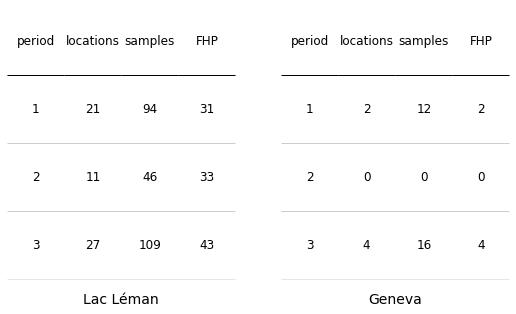

In [3]:
fhg_summary.reset_index(inplace=True)
fhg_summary["rate"] = fhg_summary.s_pos/fhg_summary["n samples"]

# assign a period to each sample
ldb['period'] = 1
ldb.loc[y_two, 'period'] = 2
ldb.loc[y_thre, 'period'] = 3

# identify the zero values
just_fhg = ldb[fhg].copy()
just_fhg['found'] = False
just_fhg.loc[(just_fhg.quantity > 0), 'found'] = True

# count the positive values y for each period and region
geneva = just_fhg[just_fhg.city.isin(city)]
summary_geneva = geneva.groupby('period', as_index=False).agg({'location':'nunique', 'loc_date':'nunique', 'found':'sum'})
summary_geneva.rename(columns={'loc_date':'samples','found':'FHP', 'location':'locations'}, inplace=True)

#there were  no samples in Geneva durring the second sampling period
summary_geneva.loc[2] = 2,0, 0, 0
summary_geneva.sort_values(by='period', inplace=True)
summary_geneva.reset_index(drop=True, inplace=True)

summary_just_fhg = just_fhg.groupby('period', as_index=False).agg({'location':'nunique', 'loc_date':'nunique', 'found':'sum'})
summary_just_fhg.rename(columns={'loc_date':'samples','found':'FHP', 'location':'locations'}, inplace=True)

fig, ax = plt.subplots(1,2, figsize=(9,5))

axone = ax[0]
axtwo= ax[1]

table_one = a_simple_formatted_table(axone,summary_just_fhg.values,colLabels=summary_just_fhg.columns, a_color="black", colWidths=[*[.25]*4], bbox=[0,0,1,1])
axone = remove_spines(axone)
axone = remove_ticks(axone)
axone.set_xlabel("Lac Léman", fontsize=14, labelpad=14)

table_two = a_simple_formatted_table(axtwo,summary_geneva.values,colLabels=summary_geneva.columns, a_color="black", colWidths=[*[.25]*4], bbox=[0,0,1,1],)
axtwo = remove_spines(axtwo)
axtwo = remove_ticks(axtwo)
axtwo.set_xlabel("Geneva", fontsize=14, labelpad=14)


plt.show()

### Method

The location with the greatest probability of finding an FHP will be determined by Bayesian inference. The statistical conclusions about a parameter $\theta$ are made in terms of probability statements. These statements conform to a commom-senses interpretation about any conclusions that may arise from the statistical analysis.  Using the Bayesian method the results of the analysis will provide an __interval of probability__ as opposed to a confidence interval. The interval of probability contains the likely values of $\theta$ given the data and our __prior beliefs__. {cite}`gelman` {cite}`pillon` {cite}`downey`

Before any probability statements can be made about the relationship between the data and $\theta$, they must be combined into a joint probability distribution. Bayes' rule does that by setting the conditional probablilty of $\theta$ to the observed data:

$$p({\theta} | data) = \frac{p(\theta)p(data | \theta)}{p(data)} \tag{1}$$

The expression to the left of the equal sign is read _"The probability of $\theta$ given data"_, which is the unobserved parameter of interest. The numerator is the product of the probability of $\theta$ and the probability of the data given $\theta$. {cite}`gelman`

The equality can be expressed in more general terms:

$$\text{posterior} = \frac{\text{prior * likelihood}}{\text{normalizing constant}} \tag{2}$$

The terms prior, posterior and likelihood have specific meanings. The prior is the estimate or belief about $\theta$ prior to collecting data. The likelihood is the chance of observing the data given $\theta$. The posterior is the distribution of the unobserved parameter ($\theta$), the value of interest. The normalizing constant is the total probability of the data and ensures that when $\theta$ is integrated on \[0,1\] it actually integrates to 1.

__The model__

To construct the model the prior, posterior and likelihood functions need to be defined. The probability of finding an FHP anywhere on the lake ranges from \[0,1\] and is not constant. Thus $\theta$ can take on different values depending on the quantity at the location of interest and the surveyors ability to find and recognize the object as an FHP.

Before defining the model the results for each survey need to be transformed to boolean values. If an FHP was recorded at a survey FHP = 1 and 0 otherwise. This reduces each survey to one idependent bernouli trial. Therefore, the probability of finding an FHP at any location can be described by the Binomial distribution, where n=number of samples and FHP=the number of times an FHP was found:

$$
\begin{align}
f(FHP|n,\theta) &= {n \choose FHP} \theta^{FHP} (1-\theta)^{ n-FHP}\\
\tag{3}
\end{align}
$$

The above expression states that "_The probability of FHP found given the number of samples and $\theta$ equals the probability density function of the Binomial distribution_". In this configuration $\theta$ only takes on one value. To account for the possible different values, $\theta$ can be set to a probability distribution that is defined on the range \[0,1\]. The Beta-Binomial model defines the probability of an event (finding an FHP) on \[0, 1\] as the function of two parameters $\alpha$ and $\beta$. By defining the value of $\theta$ as a Beta distribution with parameters the variability between locations can be better identified :

$$
\begin{align}
FHP|\theta \sim & Bin(n, \theta)\\[8pt]
\theta \sim & Beta(\alpha, \beta)
\tag{4}
\end{align}
$$

The Beta distribtion is a *conjugate prior* to the Binomial distribution and is limited to values between 0 and 1. This results in a closed form __posterior distribution__ and predictable methods for updating the parameters of Beta from one sampling period to the next. This model has many applications to any situtation where the parameter of interest is in the range \[0,1\]. {cite}`gelman` {cite}`jefferies` {cite}`bayesrules`

The probability density function of the Beta distribution is:

$$f(\theta | \alpha, \beta) = \frac{1}{Beta(\alpha, \beta)} \theta^{\alpha -1} (1-\theta)^{\beta - 1} \tag{5}$$

The general forms in 1 and 2 can now be defined using elements of 3, 4 and 5. The normalizing constant is not dependent on $\theta$ in either the Beta or Binomial distributions. 

__The prior__

When sampling started in 2015 there were no reference values for the region. Count surveys of litter data in the maritime environment had produced volumes of data but under significantly different conditions. Without reference values we had no prior assumptions on the probability of finding an FHP and assumed the probability was $\approxeq$ for all locations on the lake.

The assumed distribution of $\theta$ **prior** to November 2015 is therefore $Beta(1,1) = \frac{1}{Beta(1, 1)} \theta^{\alpha -1} (1-\theta)^{\beta - 1} = 1$ which is the standard uniform distribution. Thus reflecting the experience and expectations when sampling started.

__The probability of finding an FHP__ where n=number of samples, FHP=the number of samples with at least one FHP and $\theta$ is the probability of finding at least one FHP at a sample:

$$
\begin{align}
P(\theta | data) &=  \frac{1}{Beta(\alpha, \beta)} \theta^{\alpha -1} (1-\theta)^{\beta - 1} \cdot {n \choose FHP} \theta^{FHP} (1-\theta)^{ n-FHP} \tag{6}\\[8pt]
&\propto \theta^{\alpha -1} (1-\theta)^{\beta - 1} \cdot \theta^{FHP} (1-\theta)^{ n-FHP} \tag{7}\\[8pt]
&\propto \theta^{(\alpha + FHP) - 1} (1-\theta)^{(\beta + n - FHP) - 1} \tag{8}
\end{align}
$$

The normalizing constants that do not depend on $\theta$ are dropped (7) the result is the unormalized posterior distribution (8). It is important to note that (5) and (8) share the same form, the normalized Beta distribution. 

__Updating the model__

The posterior distribution is an unormalized Beta distribution with parameters $\alpha + FHP$ and $\beta + n - FHP$. This means that the **prior** uninformed estimate in November 2015 can be updated with the data from each sampling period in sequence. Using this method the results from sampling period one (which incorporate the initial estimate) become the **prior** distribution for the results of sampling period two and this process is repeated until the last sampling period. For example:

_Sampling period one example_

$\theta \sim Beta(1,1)$ = estimate $\theta$ prior to sampling

n - y = number of samples in period one WITHOUT an FHP

y = number of samples in period one WITH at leat one FHP

_apply n and y from the observed results to the initial estimate:_

$\theta \sim Beta( \beta = 1 + y, \alpha = 1 + n - y)$ = the estimated probability after period one **and** the prior distribution (initial estimate) for period two.

__Assumptions__

1. The samples are independent and identically distributed
2. $\theta$ $\approxeq$ for all locations which is the expected value for the lake
3. The expected result for the lake or the region is the best estimate for locations without samples
4. exchangeabilty of data

__Computational methods__

Markov Chain Monte Carlo (MCMC) is a general method used to simulate probability models.  A Markov chain is a model that describes a sequence of possible events where the probability of each event depends only on the results of the previous event. {cite}`stan` {cite}`bayesrules` {cite}`pillon`

The implementation of MCMC methods is done with PyMC3 v3.1 {cite}`pymc` and the results are analysed with ArviZ  v0.11.4 {cite}`arviz`, SciPy v1.7 {cite}`scipy`
and pandas v1.34 {cite}`pandas` all running in a Python v3.7 {cite}`python` environment.

### Results

__Lake Geneva__

Before estimating the probable values of $\theta$ for a specific location the third assumption needs to be calculated for each sampling period.

In [5]:
def model_a_sampling_period(observed, FHP, pk, names=["pLake", "thetaLake"], model_name=["yeartwo"], draws=5000):
    
    with pm.Model() as a:
    
        plake = pm.Beta(names[0], alpha=FHP, beta=pk)        
        thetaLake = pm.Binomial(names[1],  n=1, observed=observed, p=plake)

        trace = pm.sample(draws=draws, cores=4, tune=1000, return_inferencedata=False, progressbar = False, start={names[1]:[np.mean(observed)]})
        postpred = pm.sample_posterior_predictive(trace, progressbar = False, var_names=names)
        prior = pm.sample_prior_predictive()    

        priordata = az.from_pymc3(
            trace = trace,
            posterior_predictive = postpred,
            prior = prior

        )

       
    return {model_name[0]:priordata, "model": a}

def parameterize_prior(model, var_name="pLake"):
    """Makes alpha, beta parameters from the mean and standard deviation
    of the prior distribution
    """
    
    e = model["posterior_predictive"][var_name].values.flatten()
    f = len(e)
    estd = np.std(e)
    k=(((np.mean(e))*(1-np.mean(e)))/(estd**2))-1
    
    a=(np.mean(e)*k)
    b=(1-np.mean(e))*k
    
    return a, b

# model variables
# observed
observed = year_one[year_one.code.isin(code)].groupby("loc_date").fail.sum().values

# sometimes both types of FHP are found
# make everything 0 or 1
observed[observed > 1] = 1

# the first year of sampling we didn't
# know what to epxpect
FHP = 1
pk = 1

year_one_model = model_a_sampling_period(observed, FHP, pk, names=["pLake", "thetaLake"], model_name=["yearone"])

# year two
observed = year_two[year_two.code.isin(code)].groupby("loc_date").fail.sum().values

observed[observed > 1] = 1

FHP, pk = parameterize_prior(year_one_model["yearone"], var_name="pLake")

year_two_model = model_a_sampling_period(observed, FHP, pk, names=["pLake", "thetaLake"], model_name=["yeartwo"])

# year three
observed = year_three[year_three.code.isin(code)].groupby("loc_date").fail.sum().values

observed[observed > 1] = 1

# year two is the prior for year three
FHP, pk = parameterize_prior(year_two_model["yeartwo"], var_name="pLake")

year_three_model = model_a_sampling_period(observed, FHP, pk, names=["pLake", "thetaLake"], model_name=["yearthree"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pLake]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pLake]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pLake]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


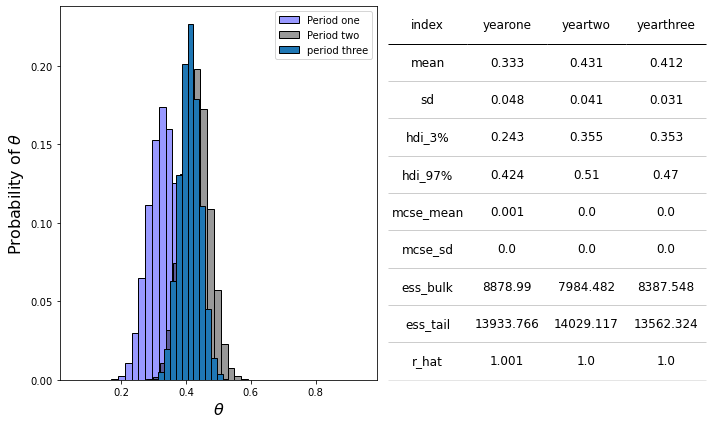

In [6]:
posts = {}
models = dict(yearone=year_one_model, yeartwo=year_two_model, yearthree=year_three_model)

# plot data
for a_model in models:
    data = models[a_model][a_model]["posterior_predictive"]["pLake"].values
    sd=[*data[0], *data[1], *data[2], *data[3]]
    
    posts.update({a_model:sd})

# summary stats
tables = []
for a_model in models:
    data = az.summary(models[a_model][a_model], fmt="long")
    data.rename(columns={"pLake":a_model}, inplace=True)
    tables.append(data)

table_data = pd.concat(tables, axis=1)
table_data.reset_index(inplace=True)

fig, axs= plt.subplots(1,2, figsize=(10,6))

# ythr_pos = lake_posteriors[2]

wght = len(posts["yearone"])

axone=axs[0]
axtwo=axs[1]

sns.histplot(np.sort(posts["yearone"]), stat='probability', color= 'blue', bins=50,binwidth=.021, alpha=.4, ax=axone, zorder=0, label='Period one')
sns.histplot(np.sort(posts["yeartwo"]), stat='probability', color='black',  bins=50, binwidth=.021, alpha=0.4, ax=axone, zorder=0,label='Period two')
sns.histplot(np.sort(posts["yearthree"]), stat='probability', ax=axone, bins=50, binwidth=.018, zorder=2, alpha=1, label="period three")

# axone.vlines(x=ythr_pos.interval(.95)[0], ymin=0, ymax=0.06, color='red')
# axone.vlines(x=ythr_pos.interval(.95)[1], ymin=0, ymax=0.06, color='red')
# axone.axvspan(xmin=ythr_pos.interval(.95)[0], xmax=ythr_pos.interval(.95)[1], ymin=0, ymax=.5, fill='x', zorder=100, alpha=0.2, color='red', label="95% ETI")

axone.set_xlim(.01,.99)
axone.set_xlabel(r"$\theta$", fontsize=16)
axone.set_ylabel(r"Probability of $\theta$", fontsize=16)

axone.legend()

table_two = a_simple_formatted_table(axtwo,table_data.values,colLabels=table_data.columns, a_color="black", colWidths=[*[.25]*4], bbox=[0,0,1,1])
axtwo = remove_spines(axtwo)
axtwo = remove_ticks(axtwo)
# axtwo.set_xlabel("Geneva", fontsize=14, labelpad=14)

plt.tight_layout()
plt.show()

*__Above:__ Figure 1, the distribution of $\theta_{FHP}$ on Lake Geneva for each sampling period. At the end of year one it was apparent that the probability of finding FHPs was not the same at every survey. The expected probability is highest in year two, but the smallest 95% HDI is in year three 15.1%.* 

__Geneva__

Recall that there were no samples in period two and that not all locations are sampled in each sampling period (table two). The assumpion is that without other evidence, $\theta$ at any location is $\approxeq$ to $\theta$ for the lake. This concept is reciprocal, if $\theta$ lake is under consideration all locations that have valid samples on the lake are included in the estimation, (figure 1). Evidence is defined as sample results.

In [19]:
ldng.period.unique()

array([2, 3, 1])

In [20]:
# the locations of interest
locs = dfBeaches[(dfBeaches.city == "Genève")&(dfBeaches.water == "l")].index.unique()
thetaunicode = "\u03B8"

# the aggregated survey data
ldng = ldb[(ldb.code.isin(code))][["period","location", "fail", "loc_date"]].copy()
ldng =  ldng.groupby(["loc_date","location", "period"], as_index=False).agg({"fail":"sum"})


periods = ["yearone", "yeartwo", "yearthree"]
results = {beach:{} for beach in locs}

def make_models_for_each_period(a_beachx, period, draws=2000):
    
    names = [f"p-{a_beachx}", f"{thetaunicode}-{a_beachx}"]         
    index = len(period)
    
    # all the data up to the period specified in period
    # period is an array of index values that correspond
    # to the sampling periods
    prior_data = ldng.loc[(ldng.period.isin(period))].groupby(["loc_date"]).fail.sum().to_numpy()
    
    # in some surveys both objects were identified
    # anything greater than zero is considerered 1
    prior_data[prior_data > 1] = 1
    
    # the number of times an FHP was found
    FHP = sum(prior_data)
    
    # the number of samples
    samps = len(prior_data)
    
    # the number times an FHP was not found
    pk= samps-FHP        

    observed = ldng.loc[(ldng.location.isin([a_beachx]))&(ldng.period.isin([3]))].groupby(["loc_date"]).fail.sum().values
    
    observed[observed > 1] = 1

    # in some surveys both objects were identified
    # anything greater than zero is considerered 1        
    if len(observed):
        pass 

    else:
        # which is the same as .5
        observed = [0,1]

    model_name = f"{a_beachx}-{periods[index]}"

    # returns an arviz data set
    modelx = model_a_sampling_period(observed, FHP, pk, names=names, model_name=[model_name], draws=draws)

    # update the dictionary       
    results[a_beachx].update({"model":modelx[model_name]})

# make a model fore each beach
for each_beach in locs:
    make_models_for_each_period(each_beach, [1,2], draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p-baby-plage-geneva]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p-baby-plage-ii-geneve]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p-jardin-botanique]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.6960843557843425, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess samplin

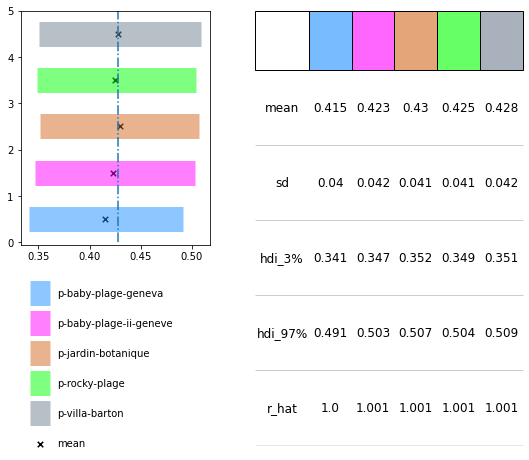

In [21]:
from matplotlib.gridspec import GridSpec

# table of summary values
tables = []
for a_model in results:
    data = az.summary(results[a_model]["model"], fmt="long")
    tables.append(data)

table_data = pd.concat(tables, axis=1)
table_data.drop(["ess_bulk", "ess_tail", "mcse_mean", "mcse_sd"], inplace=True)
table_data.reset_index(inplace=True)

# the HDI per location
hdis = table_data.columns[1:]
hdi = table_data.loc[[0,2,3],:][hdis]
hdi.loc[:, hdis[0]].values

# palette    
colorsx = ["dodgerblue","magenta", "chocolate", "lime", "slategrey"]

fig = plt.figure(figsize=(9,8))

gs=GridSpec(11, 13, figure=fig)

axone = fig.add_subplot(gs[0:6,0:5])
axtwo = fig.add_subplot(gs[0:, 6:])

maxBeach = hdis[-1]

for i,beach in enumerate(hdis):
    data = hdi.loc[:, hdis[i]].values
    axone.hlines(y=i+.5, xmin=data[1], xmax=data[2], color=colorsx[i], linewidth=25,label=beach, alpha=.5)
    axone.scatter(y=i+.5, x=data[0], c="black", marker="x", s=30, label="mean")
    if beach == maxBeach:
        axone.vlines(x=data[0], ymin=0, ymax=len(hdis), linestyle="-.")

axone.set_ylim(-.05, len(hdis))
handles, labels = axone.get_legend_handles_labels()

# remove the repetive labels
nh = handles[::2]
nl = labels[::2]

# put one back in
nl.append(labels[-1])
nh.append(handles[-1])

axone.legend(nh, nl, bbox_to_anchor=[0,-.15], loc="upper left", labelspacing=2, borderpad=.4, frameon=False)

table_two = a_simple_formatted_table(axtwo,table_data.values,colLabels=table_data.columns, coded_labels=True, codes=["white",*colorsx], colWidths=[.2, *[.16]*5], bbox=[0,0,1,1])
axtwo = remove_spines(axtwo)
axtwo = remove_ticks(axtwo)


plt.show()

*__Above:__ Figure 2, the probable values of $\theta_{FHP}$ for the survey locations in Geneva. __Left:__ the difference in means is less than 0.01 for any of the locations. __Right:__ villa-barton has the highest min and max HDI values.* 

## Conclusion

The field operations manager, Shannon Erismann, decided that the best chances of finding an FHP was at villa-barton. She considered the proximity to the train station and the time it takes to complete a survey as well as the likelihood of finding an FHP. The locations on the left bank of the lake,  (baby-plage, rocky-plage and baby-plage-ii) had only 3/14 positive samples in the most recent sampling period, well below the mean for the lake. FHP had been found at villa-barton and at jardin-botanique previously (4/15) and those locations had only been sampled twice in the previous period, (annex table 2a).

The probabiltiy of finding an FHP in Geneva at a beach litter survey is between 20% and 40% which is less than the rest of the lake (32%-47%). The chances tend to be greater, +1% on the right bank if a suitable location to sample can be found. Whether or not this can be generalized to the "Petit Lac" was not explored. 

__Significance__

The signifigance of these results depends on the question:

> $H_{0}$ : The chance of finding at least one FHP on the beach is less than 20% at each survey.

> $H_{1}$ : The chance of finding an FHP is greater than 20% at each survey

The alternative hypothesis is the most likely, the minimum 3% HDI for the lake or Geneva is 24%, making values less than 24% highly unlikely. Locations that have values in these lower ranges may have practices or methods that help reduce the incidence of these objects. 

> $H_{0}$: The chance of finding an FHP is the same for all locations in Geneva

> $H_{1}$: The chance of finding an FHP is different for all locations in Geneva

The null hypothesis is the most likely. Each location has a unique mean but the 94% HDIs are very similar, suggesting that values above and below the mean are equally likely for each location. The small differences between the means can be exploited to improve chances of finding an FHP by 1% at best.

__Covariates__

Another measure of significance could be the value of covariates tested under the same conditions. Cotton swabs are associated with the same source as FHP but are found more frequently. {cite}`iqaasl`

In [23]:
# %%capture
# the locations of interest
locs = dfBeaches[(dfBeaches.city == "Genève")&(dfBeaches.water == "l")].index.unique()
# thetaunicode = "\u03B8"

code = ["G95"]

# the aggregated survey data
ldng = ldb[(ldb.code.isin(code))][["period","location", "fail", "loc_date"]].copy()
ldng =  ldng.groupby(["loc_date","location", "period"], as_index=False).agg({"fail":"sum"})


periods = ["yearone", "yeartwo", "yearthree"]
results = {beach:{} for beach in locs}

# make a model for each beach
for each_beach in locs:
    make_models_for_each_period(each_beach, [1,2], draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p-baby-plage-geneva]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p-baby-plage-ii-geneve]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p-jardin-botanique]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p-rocky-plage]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
The 

In [24]:
tables = []
for a_model in results:
    data = az.summary(results[a_model]["model"], fmt="long")
    tables.append(data)

table_data = pd.concat(tables, axis=1)
table_data.drop(["ess_bulk", "ess_tail", "mcse_mean", "mcse_sd"], inplace=True)
table_data.reset_index(inplace=True)

# palette    
colorsx = ["dodgerblue","magenta", "chocolate", "lime", "slategrey"]

# the HDI per location
hdis = table_data.columns[1:]
hdi = table_data.loc[[0,2,3],:][hdis]
hdi.loc[:, hdis[0]].values
hdi = hdi.sort_values(by=0, axis=1, ascending=False)

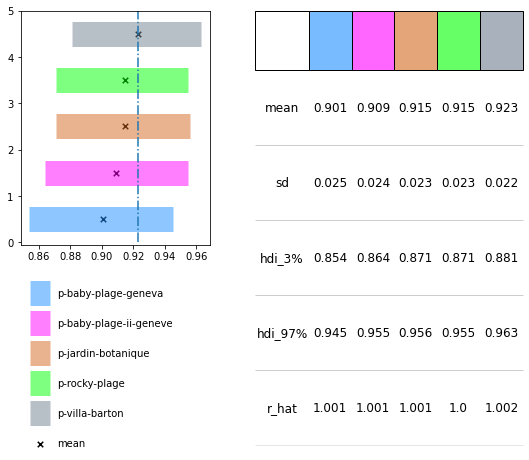

In [25]:
fig = plt.figure(figsize=(9,8))

gs=GridSpec(11, 13, figure=fig)

axone = fig.add_subplot(gs[0:6,0:5])
axtwo = fig.add_subplot(gs[0:, 6:])

maxBeach = hdis[-1]

for i,beach in enumerate(hdis):
    data = hdi.loc[:, hdis[i]].values
    axone.hlines(y=i+.5, xmin=data[1], xmax=data[2], color=colorsx[i], linewidth=25,label=beach, alpha=.5)
    axone.scatter(y=i+.5, x=data[0], c="black", marker="x", s=30, label="mean")
    if beach == maxBeach:
        axone.vlines(x=data[0], ymin=0, ymax=len(hdis), linestyle="-.")

axone.set_ylim(-.05, len(hdis))
handles, labels = axone.get_legend_handles_labels()

# remove the repetive labels
nh = handles[::2]
nl = labels[::2]

# put one back in
nl.append(labels[-1])
nh.append(handles[-1])

axone.legend(nh, nl, bbox_to_anchor=[0,-.15], loc="upper left", labelspacing=2, borderpad=.4, frameon=False)

table_two = a_simple_formatted_table(axtwo,table_data.values,colLabels=table_data.columns, coded_labels=True, codes=["white",*colorsx], colWidths=[.2, *[.16]*5], bbox=[0,0,1,1])
axtwo = remove_spines(axtwo)
axtwo = remove_ticks(axtwo)


plt.show()

*__Above:__ Figure 3, the probable values of $\theta_{cotton-swabs}$ for the survey locations in Geneva. __Left:__ villa-barton has the highest average value by at least 1%. __Right:__ the 94% HDI ranges from 89% - 98%, approximately half the range for FHP.*

When cotton swabs are considered the difference between villa-barton and the other locations is more evident. The probable range of values is between 85% and 98% a 13% difference compared to 20% for FHP. The elevated frequency of cotton swabs at the same place as FHP is consistent with previous results.

If you absolutley need to find an FHP and are in Geneva then any information that can help you find one would be considered significant. If you are wondering about the occurence of other items and their rates of occurences then this is significant. If you are interested in building a recommender system that helps identify locations that accumulate or generate trash based on observations this may be significant, it is at least a starting point.

__Ellas' adventure: the epilogue__

Shannon gave a meeting place and time. A beach litter survey was conducted an FHP was found. ELla was on time for her meeting with the staff at Procter and Gamble. {cite}`20minutes`

## Discussion

The answer to Ellas question is at the heart of the multiple calls to reduce marine litter. It also has implications in the fields of marketing, life cycle assessment, envrionmental stewardship and governance. The EU released guidelines to calculate the median and threshold values of beach litter surveys conducted on European Seas. The results are intended to evaluate the _Good environmental standing_ of the locations surveyed according to the Marine Strategy Framework Directive (MSFD). The threhold value for _Good environmental standing_ was set at 20 objects of trash per 100 meters of beach.{cite}`eubaselines`

This can be a tricky situation for stakeholders and regional adminsitrations. Consider a beach-litter survey as a detailed customer feedback form. At the same time that regional managers are trying to determine optimal resource allocation strategies, end users are planning the location of the next weekend getaway. In either case reliable data and transparent analysis methods are essential to making an informed decision.

That these results correspond with the experience of the surveyors follows from the math. The derivation of the Beta-Binomial conjugate model is more complex than the its' proposition: `each survey within a region adds to the cumulative knowledge of that region and the locations that were surveyed`. This defines the benefit both of collecting data by hand and reporting the results as a likelihood or expectation of what a person may find. This often overlooked advantage imparts three critical pieces of information to the decision maker:

> What the status was

> What it would most likely be today

> The source of the information

If the survey results are considered reliable, stakeholders have a method to anticipate the user-experience and enact policies to improve that experience. This reduces the chances of miss communication and places the assessment of quality and satisfaction into the hands of the end-user. Many companies have used this formula to improve product quality and customer satisfaction. For producers of goods that appear on beach-litter surveys there is now a method to determine how likely a product will end up on a survey. This gives another metric to determine the accuracy of the LCA and improve product outcomes with respect to end of life cycle.

The importance or signifigance of the results between individual beaches is allways a function of the number of samples at each beach. The assumption is that the probability of finding an object is about the same as the rest of the lake. Locations that have fewer samples in the most recent sampling period will tend to resemble the lake values more closely than locations that have more samples. The longer a location goes unsampled, the less weight its previous samples carry in the posterior distribution.

Underpinning all of this potential is data reliability. There is tremendous pressure for organizations to _collect data_. A parallel structure to ensure good practices is yet to be proposed. If some portion of survey data variability can be attributed to the surveyor then there should be processes inplace to ensure that surveys are conducted in a consistent manner. 

__Next steps__

The model proposed is scalable and reliable, the accuracy depends on the 94% HDI. Defining or locating more efficient methods to calculate the probability for all integer values would allow for the generalization of this process to all objects and locations. Understanding how the probability changes with respect to different independent variables can help stakeholders identify sources. The first steps were taken when $\theta_{FHP}$ for all locations on lake were considered (annex Figure 1a).

## Annex

*__Below:__ Table 1a, the number of samples and the ratio of samples where at least one FHP was identified (rate).*

In [12]:
fhg_summary[fhg_summary["n samples"] > 2][["city","location", "n samples", "s_pos", "rate"]]

,city,location,n samples,s_pos,rate
0,Allaman,la-pecherie,3,3.0,1.000000
2,Genève,baby-plage-geneva,11,3.0,0.272727
4,Genève,jardin-botanique,3,2.0,0.666667
6,Genève,villa-barton,11,1.0,0.090909
7,Gland,lacleman_gland_kubela,11,3.0,0.272727
8,Gland,lacleman_gland_lecoanets,11,4.0,0.363636
10,La Tour-de-Peilz,bain-des-dames,4,3.0,0.750000
12,La Tour-de-Peilz,maladaire,15,3.0,0.200000
13,La Tour-de-Peilz,oyonne,3,2.0,0.666667
14,Lausanne,lacleman_vidy_santie,12,10.0,0.833333


In Geneva there were 16 samples in period three and 12 samples in the first period. Using the same method as above the range of probable values in Geneva ranges from 0 to 66%. A probability of 0 is not realistic and 12/28 samples are almost four years old. The range of possible values reflects how uncertain any prediction may be using these methods.

*__Table 2a:__ locations, number of samples and number of samples with at least one FHP in Geneva*

In [13]:
glocs_summary = geneva.groupby(['location', 'period'], as_index=False).agg({'loc_date':'nunique', 'fail':'sum'})
glocs_summary.rename(columns={'loc_date':'samples','fail':'FHP', 'location':'locations'}, inplace=True)
glocs_summary

,locations,period,samples,FHP
0,baby-plage-geneva,3,11,3
1,baby-plage-ii-geneve,3,2,0
2,jardin-botanique,1,3,2
3,rocky-plage,3,1,0
4,villa-barton,1,9,0
5,villa-barton,3,2,1


Villa-barton had 0/9 positive samples in the first period and 1/2 in the third period. Jardin-botanique had 2/3 in period one but has not been sampled since. To account for the results from prior  sampling periods bayesian inference will be used to estmate the location in Geneva that may have the highest value of $\theta$ with respect to the other locations given the previous survey results.

In [30]:
# the locations of interest
locs = dfBeaches[(dfBeaches.water_name_slug == "lac-leman")&(dfBeaches.water == "l")].index.unique()
thetaunicode = "\u03B8"

# the aggregated survey data

code = ["G96", "G144"]
ldng = ldb[(ldb.code.isin(code))][["period","location","loc_date", "p/100m"]].copy()

ldng =  ldng.groupby(["loc_date","location", "period"], as_index=False).agg({"p/100m":"sum"})
ldng["fail"] = ldng["p/100m"] > 0


periods = ["yearone", "yeartwo", "yearthree"]
results = {beach:{} for beach in locs}



In [31]:
# make a model fore each beach
for each_beach in locs:
    make_models_for_each_period(each_beach, [1,2], draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p-anarchy-beach]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8835125816871173, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p-arabie]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p-baby-plage-geneva]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 

In [33]:
tables = []
for a_model in results:
    data = az.summary(results[a_model]["model"], fmt="long")
    tables.append(data)

table_data = pd.concat(tables, axis=1)
table_data.drop(["ess_bulk", "ess_tail", "mcse_mean", "mcse_sd"], inplace=True)
table_data.reset_index(inplace=True)

colorsx = plt.cm.get_cmap("hsv", len(locs))

# the HDI per location
hdis = table_data.columns[1:]
hdi = table_data.loc[[0,2,3],:][hdis]
hdi.loc[:, hdis[0]].values
hdi = hdi.sort_values(by=0, axis=1, ascending=False)

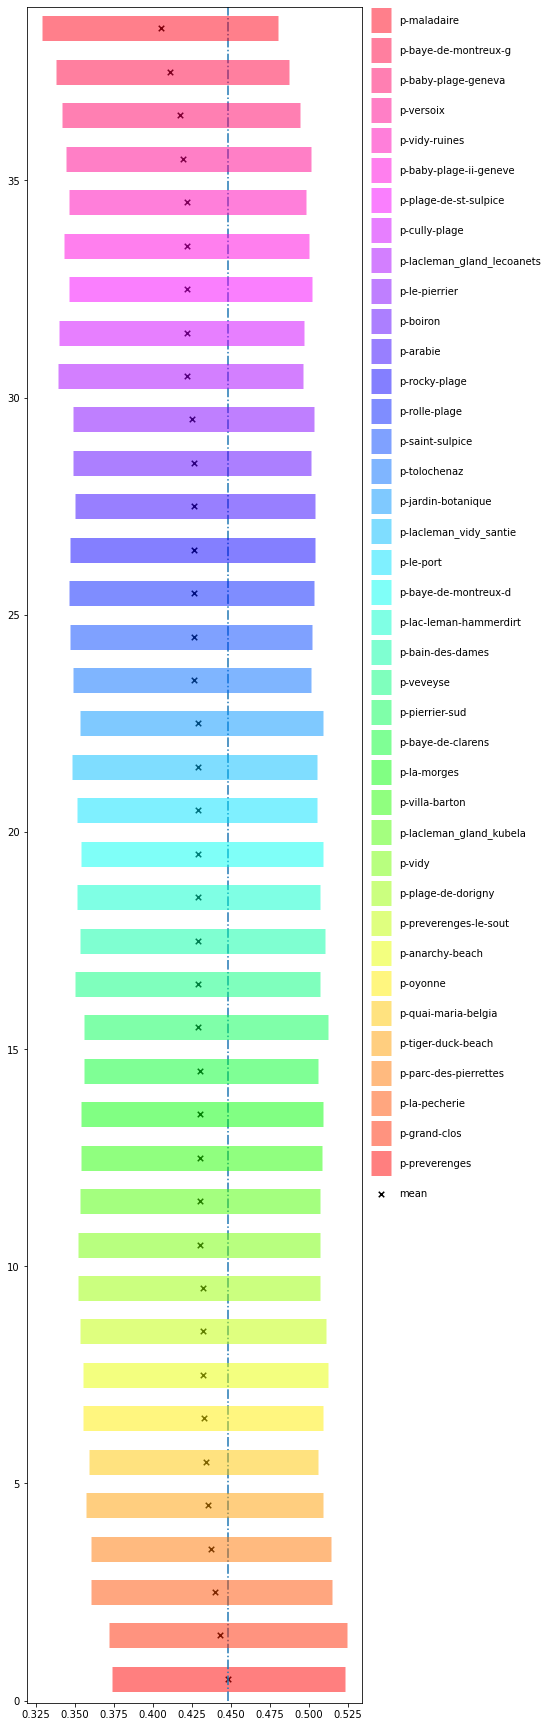

In [34]:
fig, ax = plt.subplots(figsize=(6, len(locs)*.8))

axone= ax

colorsx = plt.cm.get_cmap("hsv", len(locs))

maxBeach = hdi.columns[0]

for i,beach in enumerate(hdi.columns):
    data = hdi.loc[:, beach].values
    axone.hlines(y=i+.5, xmin=data[1], xmax=data[2], color=colorsx(i), linewidth=25,label=beach, alpha=.5)
    axone.scatter(y=i+.5, x=data[0], c="black", marker="x", s=30, label="mean")
    if beach == maxBeach:
        axone.vlines(x=data[0], ymin=0, ymax=len(hdis), linestyle="-.")

axone.set_ylim(-.05, len(hdis))
handles, labels = axone.get_legend_handles_labels()

# remove the repetive labels
nh = handles[::2]
nl = labels[::2]

nh = nh[::-1]
nl = nl[::-1]

# put one back in
nl.append(labels[-1])
nh.append(handles[-1])

axone.legend(nh, nl, bbox_to_anchor=[1,1], loc="upper left", labelspacing=2, borderpad=.4, frameon=False)

# table_two = a_simple_formatted_table(axtwo,table_data.values,colLabels=table_data.columns, coded_labels=True, codes=["white",*colorsx], colWidths=[.2, *[.16]*5], bbox=[0,0,1,1])
# axtwo = remove_spines(axtwo)
# axtwo = remove_ticks(axtwo)


plt.show()


In [29]:
author = "roger@hammerdirt.ch"
my_message = "\u2764\ufe0f what you do."
md(F"""
<br></br>
**Hammerdirt everyday.**<br>

>{my_message}<br>

*{author}* pushed the run button.<br>
This document originates from https://github.com/hammerdirt-analyst/ all copyrights apply.<br>
""")


<br></br>
**Hammerdirt everyday.**<br>

>❤️ what you do.<br>

*roger@hammerdirt.ch* pushed the run button.<br>
This document originates from https://github.com/hammerdirt-analyst/ all copyrights apply.<br>
